In [1]:
using LinearAlgebra, Plots
# 函数定义
@inline function get_Phi(q)
    return (q'*q .- 1)/2
end

@inline function get_Phiq(q)
    return q'
end

function comp_u(q0, U, V, B, u, v, utol)
    gamma = get_Phi(q0 + V*v - U*u)
    while norm(gamma) > utol
        u = u .+ B*gamma
        gamma = get_Phi(q0 + V*v - U*u)
    end
    return u
end

function comp_B(q, U, B, Btol)
    PhiqU = get_Phiq(q)*U
    gamma = PhiqU*B
    eye = I(size(gamma, 1))
    while norm(gamma .- eye) > Btol
        B = 2*B .- B*gamma
        gamma = PhiqU*B
    end
    return B
end

function comp_D(q0, V, q)
    q0qT = q0*q'
    return (I(size(q0qT, 1)) - q0qT./(q'*q0))*V
end

function comp_ddq(q0, D, q, dq, ddv)
    return D*ddv - (dq'*dq)./(q'*q0)*q0
end

function comp_ddv(q0, D, q, dq)
    m = 1 # 质量
    g = 9.8 # 重力加速度
    uz = [0; 0; 1] # 重力方向
    M = m*D'*D
    N = m*D'*(dq'*dq)/(q'*q0)*q0-m*g*D'*uz
    return M\N
end

comp_ddv (generic function with 1 method)

In [2]:
# 参数设置
q0 = [0; 0; 1]
dq = [0; 1; 0]
utol = 1e-7
Btol = 1e-7
tStep = 1e-3
tList = collect(0:tStep:10)
qList = zeros((3, length(tList)))

3×10001 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [3]:
# 初始化
qList[:, 1] = deepcopy(q0)
q = deepcopy(q0)
U = deepcopy(q0)
V = nullspace(U')
B = inv(U'*U)
u = -U'*(q - q0)
v = V'*(q - q0)
D = comp_D(q0, V, q)
dv = D\dq
ddv = comp_ddv(q0, D, q, dq)

2-element Vector{Float64}:
 0.0
 0.0

In [4]:
# 迭代计算
for t = 2:length(tList)
    if norm(v) > 0.75
        q0 = deepcopy(q)
        U = deepcopy(q0)
        V = nullspace(U')
        B = inv(U'*U)
        u = -U'*(q - q0)
        v = V'*(q - q0)
        D = comp_D(q0, V, q)
        dv = D\dq
        ddv = comp_ddv(q0, D, q, dq)
    end
    v = v + tStep*dv
    dv = dv + tStep*ddv
    B = comp_B(q, U, B, Btol)
    u = comp_u(q0, U, V, B, u, v, utol)
    q = q0 + V*v - U*u
    qList[:, t] = deepcopy(q)
    D = comp_D(q0, V, q)
    dq = D*dv
    ddv = comp_ddv(q0, D, q, dq)
end

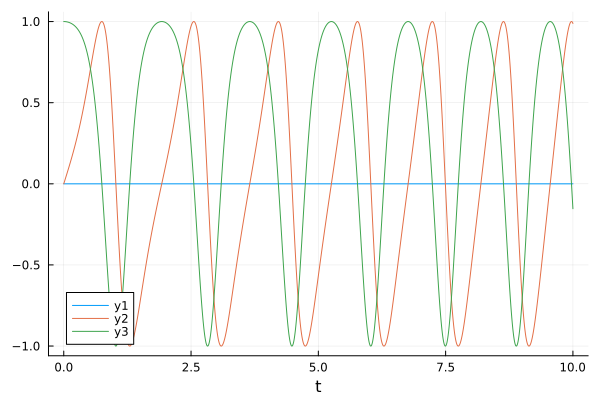

In [5]:
# 作图
plot(tList, [qList[1, :] qList[2, :] qList[3, :]])
xlabel!("t")